<a href="https://www.kaggle.com/code/yaaangzhou/s3e19-eda-baseline-model?scriptVersionId=136396709" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="font-family:verdana;"> <center> 🎯PS3 E19: Forecasting Mini-Course Sales🚀</center> </h1>

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Version 1</p>

***This notebook contains the following: import data, EDA, feature engineering, build baseline models and an ensemble model.***


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Imports</p>

In [1]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.express as px


from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Model Selection
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, TimeSeriesSplit

# Models
import optuna
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
import lightgbm as lgb



import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Adjusting plot style

rc = {
    "axes.facecolor": "#F8F8F8",
    "figure.facecolor": "#F8F8F8",
    "axes.edgecolor": "#000000",
    "grid.color": "#EBEBE7" + "30",
    "font.family": "serif",
    "axes.labelcolor": "#000000",
    "xtick.color": "#000000",
    "ytick.color": "#000000",
    "grid.alpha": 0.4
}

sns.set(rc=rc)
palette = ['#302c36', '#037d97', '#E4591E', '#C09741',
           '#EC5B6D', '#90A6B1', '#6ca957', '#D8E3E2']

from colorama import Style, Fore
blk = Style.BRIGHT + Fore.BLACK
mgt = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blu = Style.BRIGHT + Fore.BLUE
res = Style.RESET_ALL

In [3]:
test = pd.read_csv('/kaggle/input/playground-series-s3e19/test.csv')
train = pd.read_csv('/kaggle/input/playground-series-s3e19/train.csv')
sample = pd.read_csv('/kaggle/input/playground-series-s3e19/sample_submission.csv')

# change formate
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

# delete id col
train.drop(['id'],axis=1,inplace=True)
test.drop(['id'],axis=1,inplace=True)

In [4]:
train.head()

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49


In [5]:
test.head()

,date,country,store,product
0,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding
1,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs
2,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People
3,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions
4,2022-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better


In [6]:
target = ['nums_sold']
cat = ['country','store']

print('The shape of train is: ', train.shape)
print('The shape of test is: ', test.shape)

The shape of train is:  (136950, 5)
The shape of test is:  (27375, 4)


In [7]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['missing#'] = df.isnull().sum().values 
    summ['missing%'] = (df.isnull().sum().values*100)/len(df)
    summ['uniques'] = df.nunique().values
    summ['count'] = df.count().values
    desc = pd.DataFrame(df.describe(include='all').T)
    summ['min'] = desc['min']
    summ['max'] = desc['max']
    summ['mean'] = desc['mean']
    return summ

summary(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,min,max,mean
date,datetime64[ns],0,0.000000,1826,136950,nan,nan,nan
country,object,0,0.000000,5,136950,nan,nan,nan
store,object,0,0.000000,3,136950,nan,nan,nan
product,object,0,0.000000,5,136950,nan,nan,nan
num_sold,int64,0,0.000000,1028,136950,2.000000,1380.000000,165.522636


In [8]:
train.describe().T\
    .style.bar(subset=['mean'], color=px.colors.qualitative.G10[2])\
    .background_gradient(subset=['std'], cmap='Blues')\
    .background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
num_sold,136950.000000,165.522636,183.691575,2.000000,46.000000,98.000000,184.000000,1380.000000


# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">EDA</p>

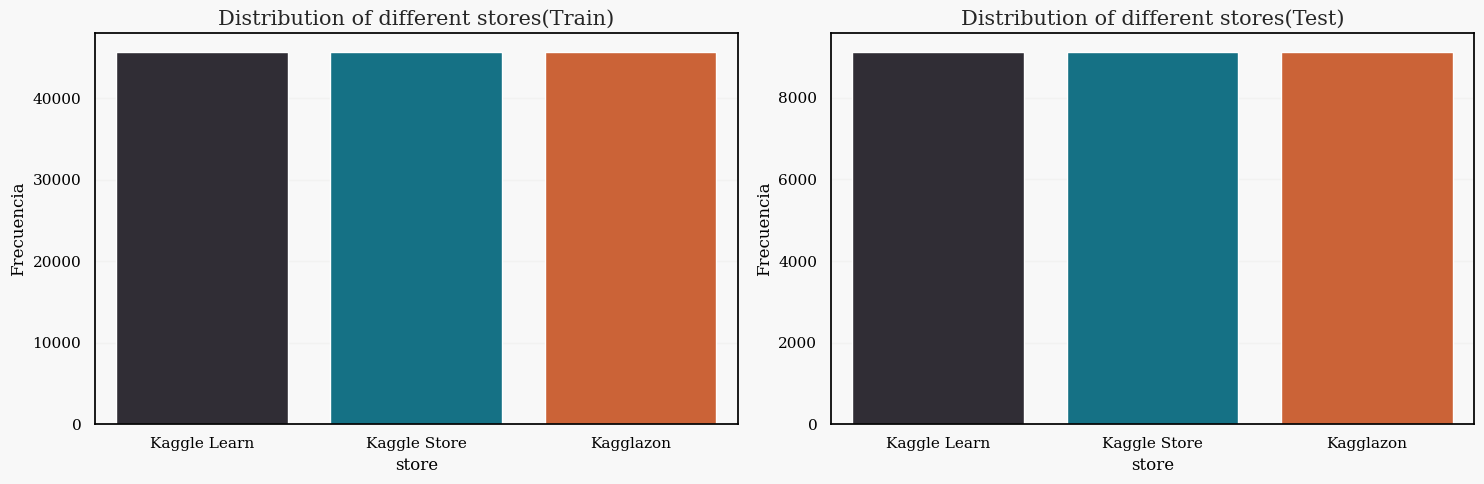

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1 = axes[0]
sns.countplot(x='store', data=train, palette=palette, ax=ax1)
ax1.set_title('Distribution of different stores(Train)', fontsize=15)
ax1.set_xlabel('store', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)

ax2 = axes[1]
sns.countplot(x='store', data=test, palette=palette, ax=ax2)
ax2.set_title('Distribution of different stores(Test)', fontsize=15)
ax2.set_xlabel('store', fontsize=12)
ax2.set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout()

plt.show()

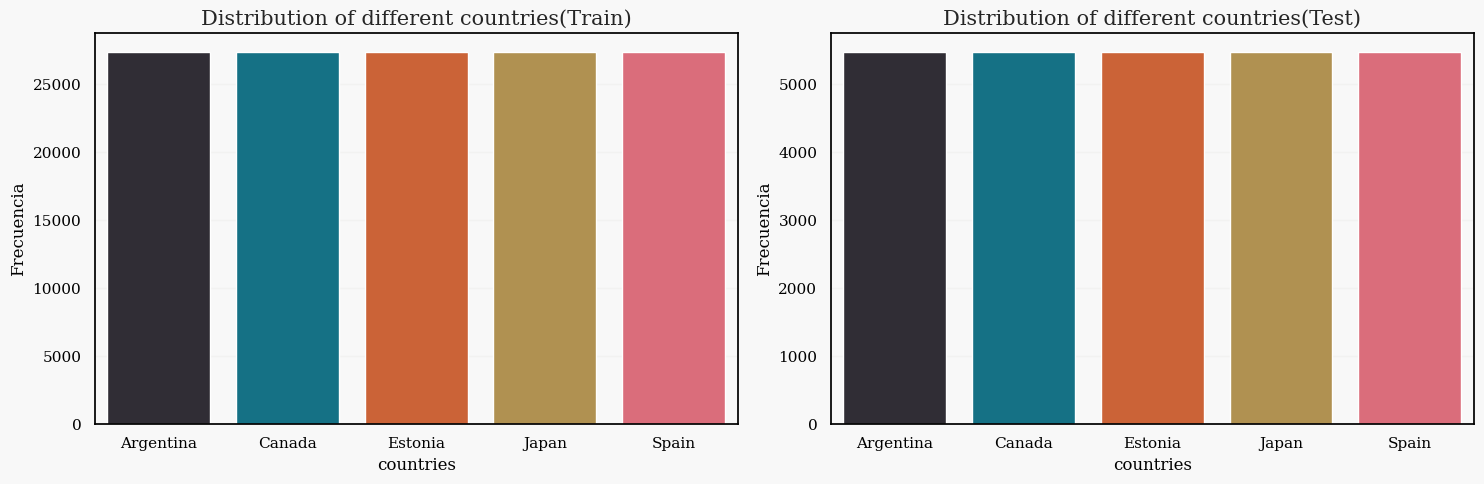

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ax1 = axes[0]
sns.countplot(x='country', data=train, palette=palette, ax=ax1)
ax1.set_title('Distribution of different countries(Train)', fontsize=15)
ax1.set_xlabel('countries', fontsize=12)
ax1.set_ylabel('Frecuencia', fontsize=12)

ax2 = axes[1]
sns.countplot(x='country', data=test, palette=palette, ax=ax2)
ax2.set_title('Distribution of different countries(Test)', fontsize=15)
ax2.set_xlabel('countries', fontsize=12)
ax2.set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout()

plt.show()

In [11]:
train_agg = train.groupby(['country', 'product']).num_sold.sum().reset_index()
train_agg.head()

,country,product,num_sold
0,Argentina,Using LLMs to Improve Your Coding,450959
1,Argentina,Using LLMs to Train More LLMs,444722
2,Argentina,Using LLMs to Win Friends and Influence People,68007
3,Argentina,Using LLMs to Win More Kaggle Competitions,376845
4,Argentina,Using LLMs to Write Better,342711


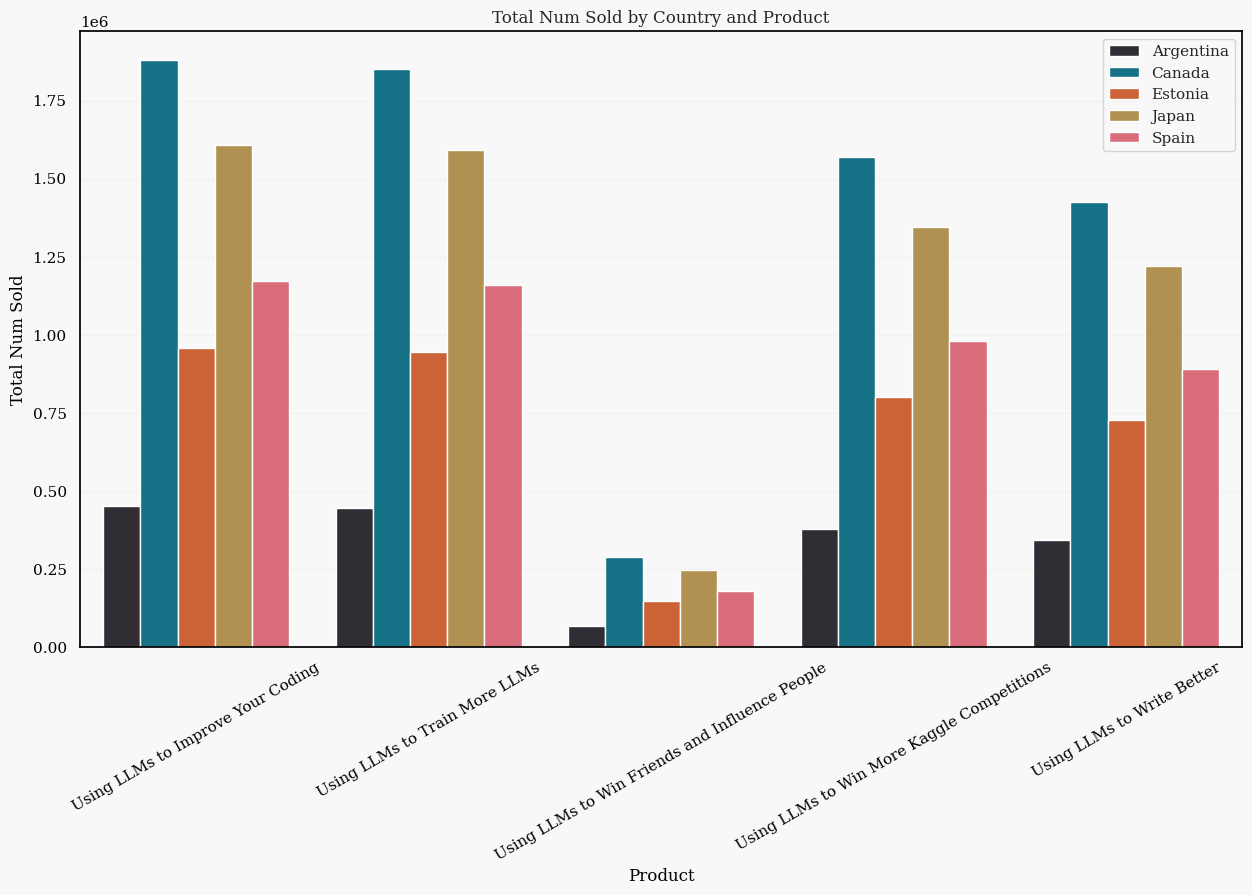

In [12]:
import seaborn as sns


plt.figure(figsize=(15, 8))
sns.barplot(x='product', y='num_sold', hue='country', data=train_agg, palette=palette)

plt.title('Total Num Sold by Country and Product')
plt.xlabel('Product')
plt.ylabel('Total Num Sold')
plt.xticks(rotation=30)
plt.legend()

plt.show()


In [13]:
train_agg['country'].unique()

array(['Argentina', 'Canada', 'Estonia', 'Japan', 'Spain'], dtype=object)

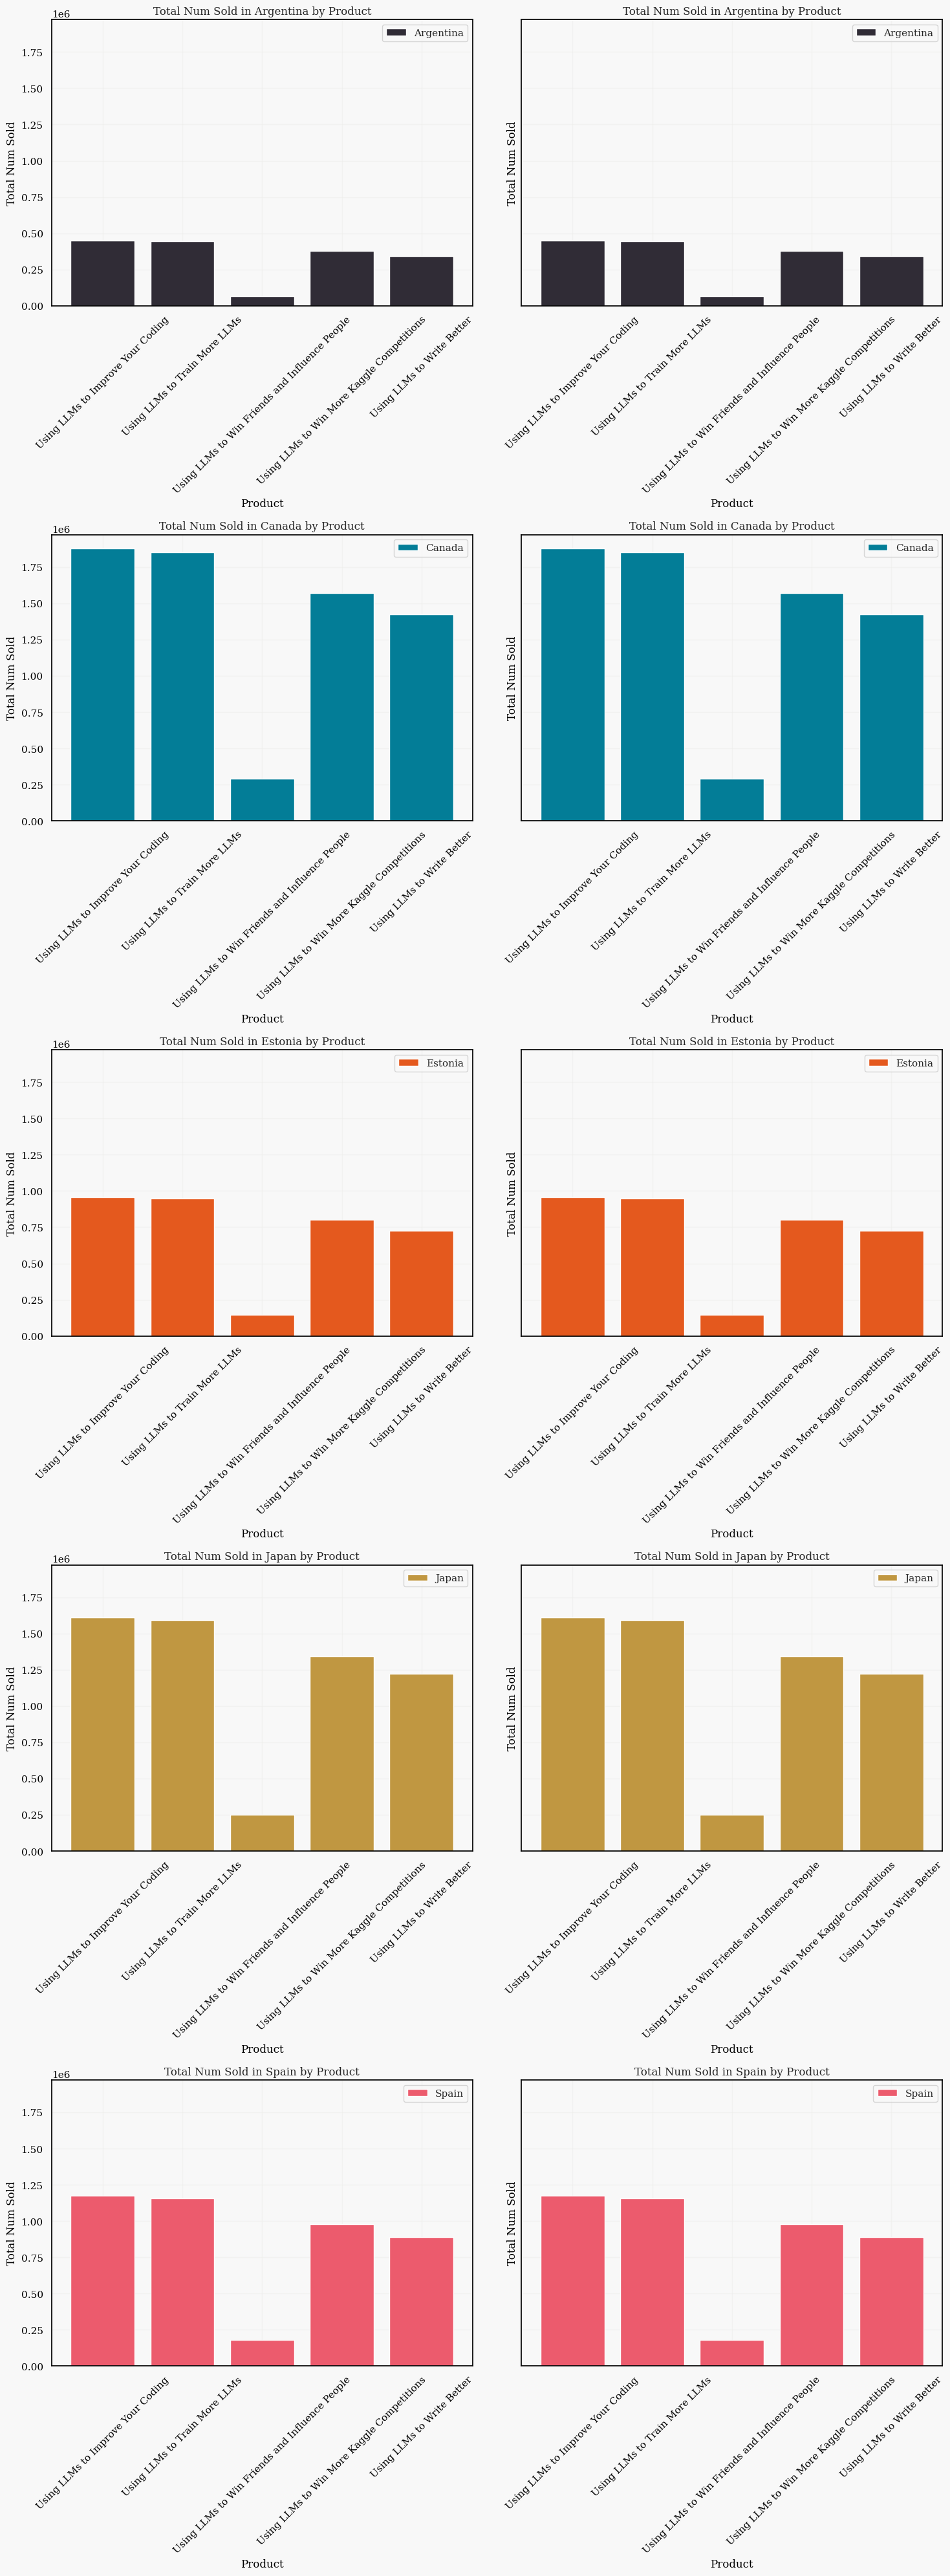

In [14]:
countries = train_agg['country'].unique()
fig, axs = plt.subplots(len(countries), 2, figsize=(15, 8*len(countries)), sharey=True)

for i, country in enumerate(countries):
    country_df = train_agg[train_agg['country'] == country]
    axs[i, 0].bar(country_df['product'], country_df['num_sold'], color=palette[i], label=country)
    axs[i, 0].set_title(f'Total Num Sold in {country} by Product')
    axs[i, 0].set_xlabel('Product')
    axs[i, 0].set_ylabel('Total Num Sold')
    axs[i, 0].legend()
    axs[i, 0].tick_params(axis='x', rotation=45)
    
    axs[i, 1].bar(country_df['product'], country_df['num_sold'], color=palette[i], label=country)
    axs[i, 1].set_title(f'Total Num Sold in {country} by Product')
    axs[i, 1].set_xlabel('Product')
    axs[i, 1].set_ylabel('Total Num Sold')
    axs[i, 1].legend()
    axs[i, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()



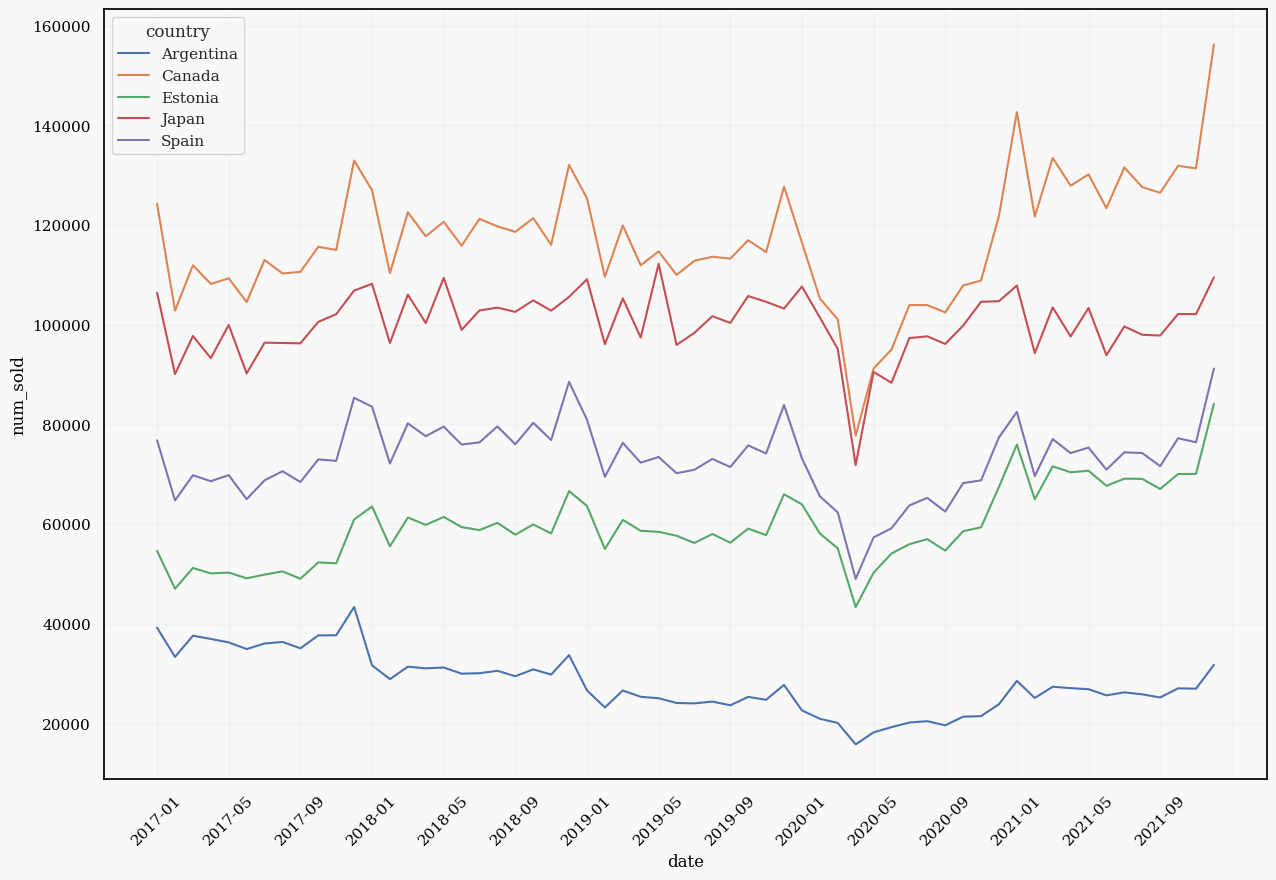

In [15]:
plt.figure(figsize = (15, 10))

ax = sns.lineplot(data = train.groupby([train.date.dt.strftime('%Y-%m'), train.country])['num_sold'].sum().reset_index(),
                  x = 'date',
                  y = 'num_sold',
                  hue ='country')

ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20))
plt.xticks(rotation = 45);

In [16]:
ts_train = train.groupby(['date', 'product', 'country'], as_index=False)['num_sold'].sum()
ts_train

,date,product,country,num_sold
0,2017-01-01,Using LLMs to Improve Your Coding,Argentina,491
1,2017-01-01,Using LLMs to Improve Your Coding,Canada,1517
2,2017-01-01,Using LLMs to Improve Your Coding,Estonia,725
3,2017-01-01,Using LLMs to Improve Your Coding,Japan,1375
4,2017-01-01,Using LLMs to Improve Your Coding,Spain,1023
...,...,...,...,...
45645,2021-12-31,Using LLMs to Write Better,Argentina,273
45646,2021-12-31,Using LLMs to Write Better,Canada,1344
45647,2021-12-31,Using LLMs to Write Better,Estonia,789
45648,2021-12-31,Using LLMs to Write Better,Japan,749


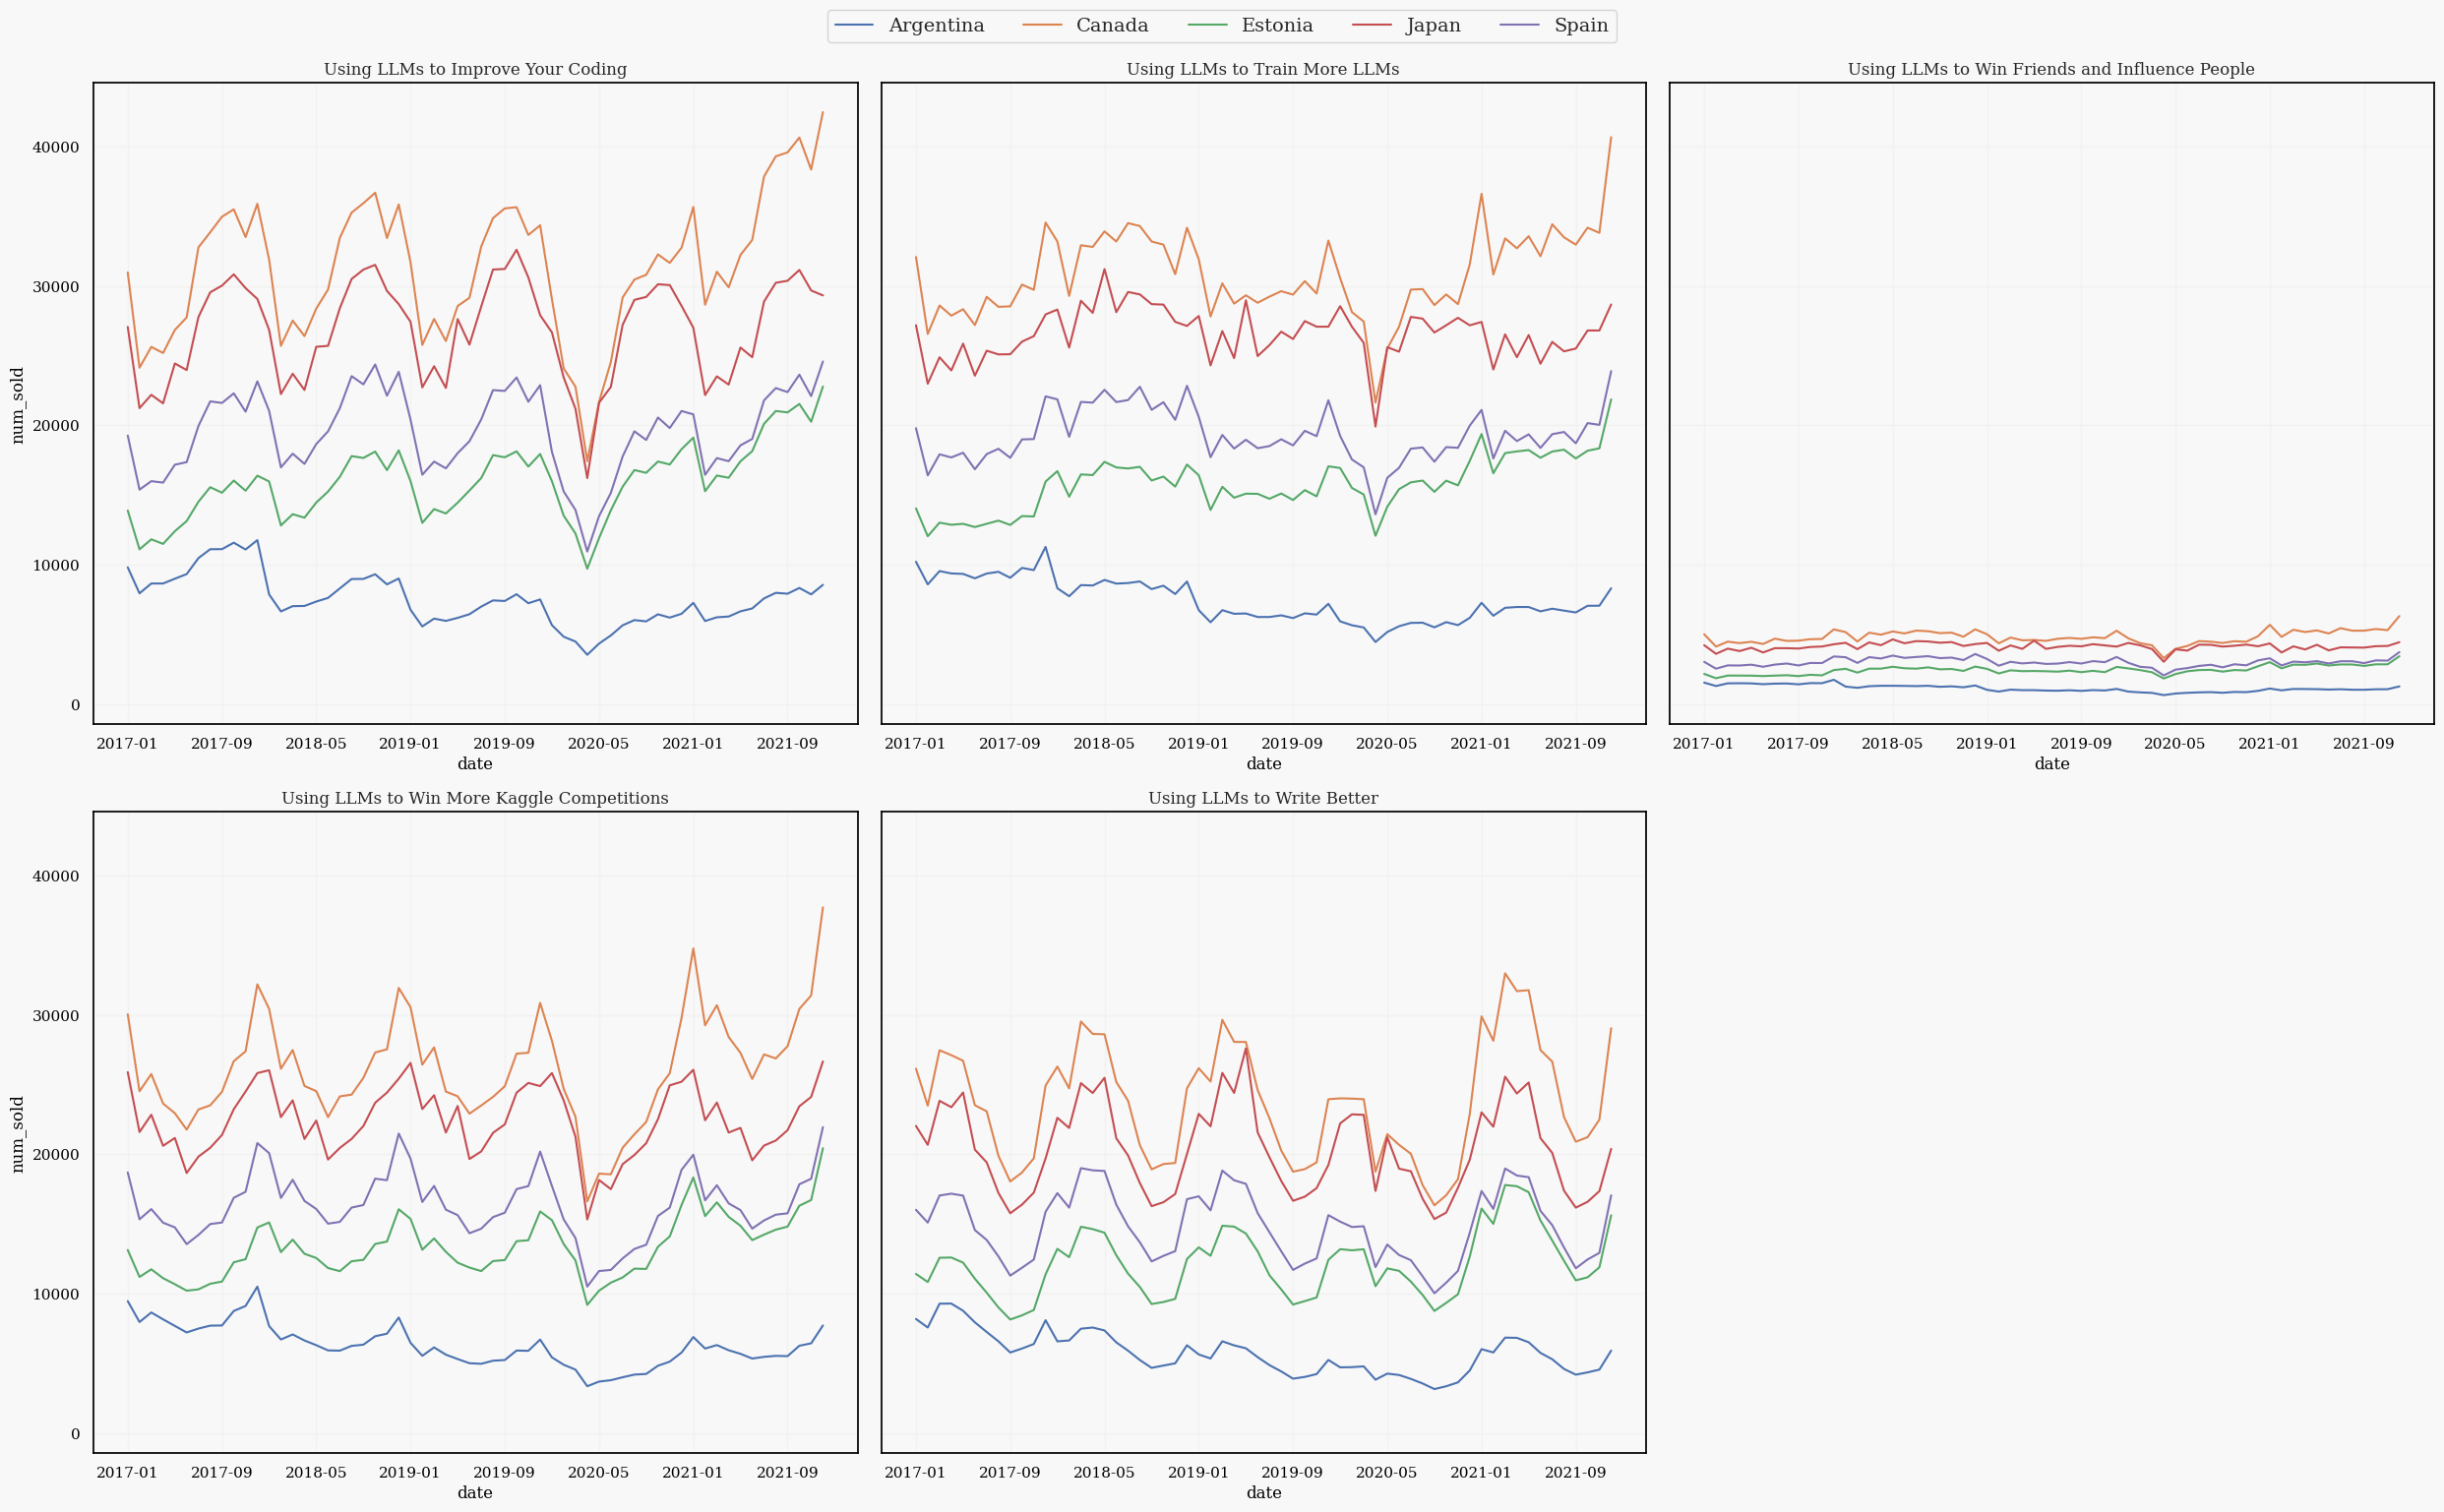

In [17]:
fig, ax = plt.subplots(2, 3, figsize = (25, 15), sharey = True)
ax = ax.flatten()

for i, product in enumerate(train['product'].unique()):
    df = train[train['product'] == product]
    sns.lineplot(data = df.groupby([df.date.dt.strftime('%Y-%m'), df.country])['num_sold'].sum().reset_index(),
                 x = 'date',
                 y = 'num_sold',
                 hue = 'country',
                 ax = ax[i],
                 hue_order = train.country.unique()
    )
    ax[i].set_title(product)
    ax[i].xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))
    
    handles = ax[i].get_legend_handles_labels()[0]
    labels = ax[i].get_legend_handles_labels()[1]
    ax[i].legend().remove()
    
for j in range(len(train['product'].unique()), len(ax)):
    fig.delaxes(ax[j])
    
fig.legend(handles, labels, loc = 'upper center', bbox_to_anchor=(0.5, 1.03), fontsize = 14, ncol = 6)
plt.tight_layout()

# <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#1871c9; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #000966">Preprocessing and Modeling</p>

In [18]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


custom_scorer = make_scorer(smape, greater_is_better=False)

In [19]:
def feature_engineer(df):    
    new_df = df.copy()
    new_df["month"] = df["date"].dt.month
    new_df["day"] = df["date"].dt.day    
    new_df["day_of_week"] = df["date"].dt.dayofweek
    new_df["daygroup_of_week"] = new_df["day_of_week"].apply(lambda x: 0 if x <= 3 else(1 if x == 4 else (2 if x == 5 else (3))))
    new_df["day_of_year"] = df["date"].dt.dayofyear
    new_df["year"] = df["date"].dt.year
    #new_df['moving_average'] = df['num_sold'].rolling(window=5).mean()
    new_df = new_df.fillna(method='bfill')
    new_df = pd.get_dummies(new_df, columns=['country', 'store', 'product'])
    return new_df

new_train = feature_engineer(train)
new_test = feature_engineer(test)

In [20]:
new_train.shape

(136950, 21)

In [21]:
new_test.shape

(27375, 20)

In [22]:
X = new_train.drop(['date', 'num_sold'], axis=1)
y = new_train[['num_sold']]
new_test = new_test.drop(['date'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [23]:
train_data = lgb.Dataset(X_train, label=y_train.values.ravel())

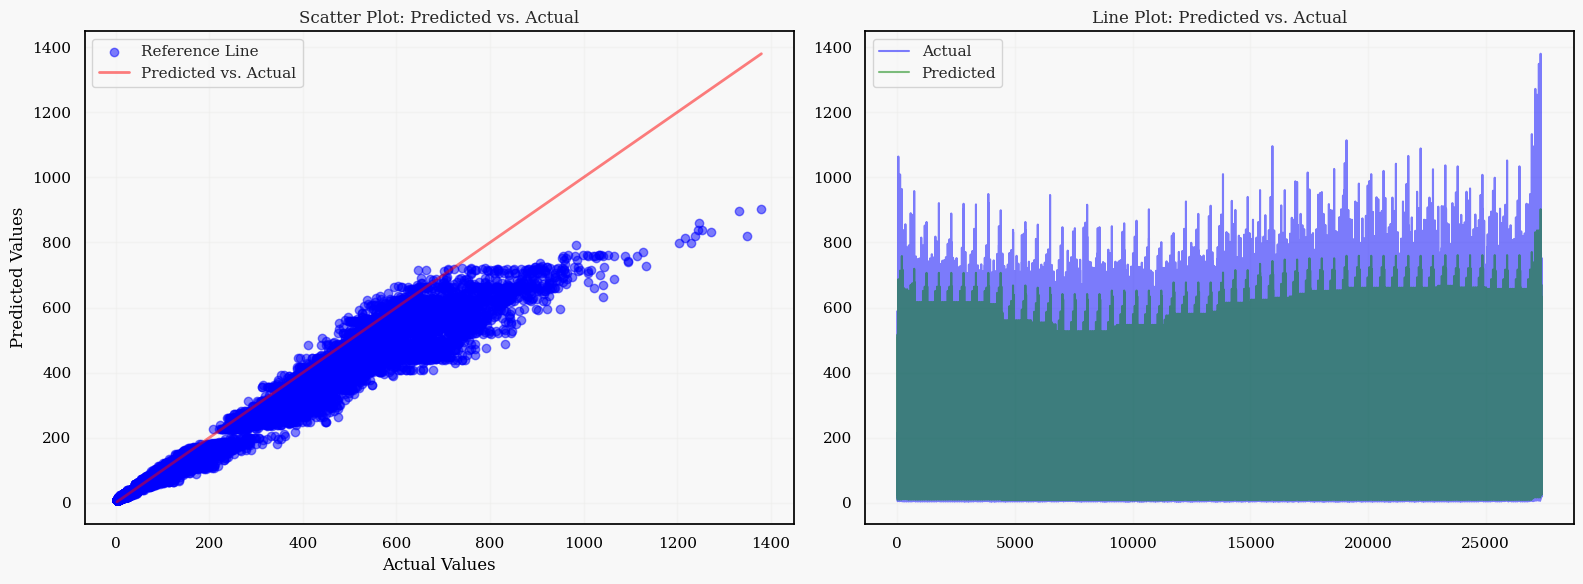

Test set SMAPE:  16.7457342868608


In [24]:
model = lgb.LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.8, device='gpu', learning_rate=0.1, metric='l1', min_split_gain=0.01, n_estimators=40, objective='regression', random_state=42, subsample=1)

model.fit(X_train, y_train.values.ravel())

# Make predictions
predictions = model.predict(X_test)

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot of actual values vs predicted values
axes[0].scatter(y_test, predictions, color='blue', alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', alpha=0.5, linewidth=2)
axes[0].set_xlabel('Actual Values')
axes[0].set_ylabel('Predicted Values')
axes[0].set_title('Scatter Plot: Predicted vs. Actual')
axes[0].legend(['Reference Line', 'Predicted vs. Actual'])

# Line plot of actual values and predicted values
axes[1].plot(y_test.values.ravel(), color='blue', alpha=0.5, label='Actual')
axes[1].plot(predictions, color='green', alpha=0.5, label='Predicted')
axes[1].set_title('Line Plot: Predicted vs. Actual')
axes[1].legend()

plt.tight_layout()
plt.show()

# Test set SMAPE
print("Test set SMAPE: ", smape(y_test.values.ravel(), predictions))

In [25]:
final_pred = model.predict(new_test)
sample['num_sold'] = final_pred
sample.rename(columns={'Unnamed: 0':'id'}, inplace=True)
sample.to_csv('Baseline_submission.csv', index = False)

In [26]:
sample

,id,num_sold
0,136950,31.667054
1,136951,31.958502
2,136952,9.675635
3,136953,31.140280
4,136954,30.181214
...,...,...
27370,164320,590.461635
27371,164321,573.669309
27372,164322,80.886931
27373,164323,538.145693
